In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import uuid

# Loading and preprocessing the data
def load_and_preprocess_data():
    # Reading the CSV data
    df = pd.read_csv('21_customer_lifetime_value.csv')

    # Handling missing or invalid values
    df = df.dropna()
    df = df[df['total_spent'] > 0]
    df = df[df['tenure'] > 0]
    df = df[df['purchase_history'] > 0]

    return df

# Feature engineering
def feature_engineering(df):
    # Calculating Recency (assuming tenure is in months)
    df['recency'] = df['tenure']

    # Calculating Frequency
    df['frequency'] = df['purchase_history']

    # Calculating Average Order Value (AOV)
    df['aov'] = df['total_spent'] / df['purchase_history']

    # Creating additional features
    df['spend_per_month'] = df['total_spent'] / df['tenure']
    df['purchases_per_month'] = df['purchase_history'] / df['tenure']

    return df

# Training and evaluating the model
def train_and_evaluate_model(df):
    # Defining features and target
    features = ['recency', 'frequency', 'aov', 'spend_per_month', 'purchases_per_month']
    X = df[features]
    y = df['CLV']

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)

    # Training models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Making predictions
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)

    # Evaluating models
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

    print("Random Forest Results:")
    print(f"MAE: {rf_mae:.2f}")
    print(f"RMSE: {rf_rmse:.2f}")
    print("\nXGBoost Results:")
    print(f"MAE: {xgb_mae:.2f}")
    print(f"RMSE: {xgb_rmse:.2f}")

    return xgb_model, features

# Segmenting customers based on predicted LTV
def segment_customers(df, model, features):
    # Predicting LTV for all customers
    df['predicted_LTV'] = model.predict(df[features])

    # Creating LTV segments
    df['LTV_segment'] = pd.qcut(df['predicted_LTV'], q=3, labels=['Low', 'Medium', 'High'])

    # Generating unique IDs for segments
    df['segment_id'] = df['LTV_segment'].apply(lambda x: str(uuid.uuid4()))

    return df

# Main execution
def main():
    # Loading and preprocessing data
    df = load_and_preprocess_data()

    # Feature engineering
    df = feature_engineering(df)

    # Training and evaluating model
    model, features = train_and_evaluate_model(df)

    # Segmenting customers
    df = segment_customers(df, model, features)

    # Saving results to Excel
    df.to_excel('customer_LTV_predictions.xlsx', index=False)

    # Printing segment distribution
    print("\nCustomer Segment Distribution:")
    print(df['LTV_segment'].value_counts())

    return df

if __name__ == "__main__":
    df = main()

Random Forest Results:
MAE: 532.31
RMSE: 768.37

XGBoost Results:
MAE: 540.20
RMSE: 764.14

Customer Segment Distribution:
LTV_segment
Medium    334
Low       333
High      333
Name: count, dtype: int64


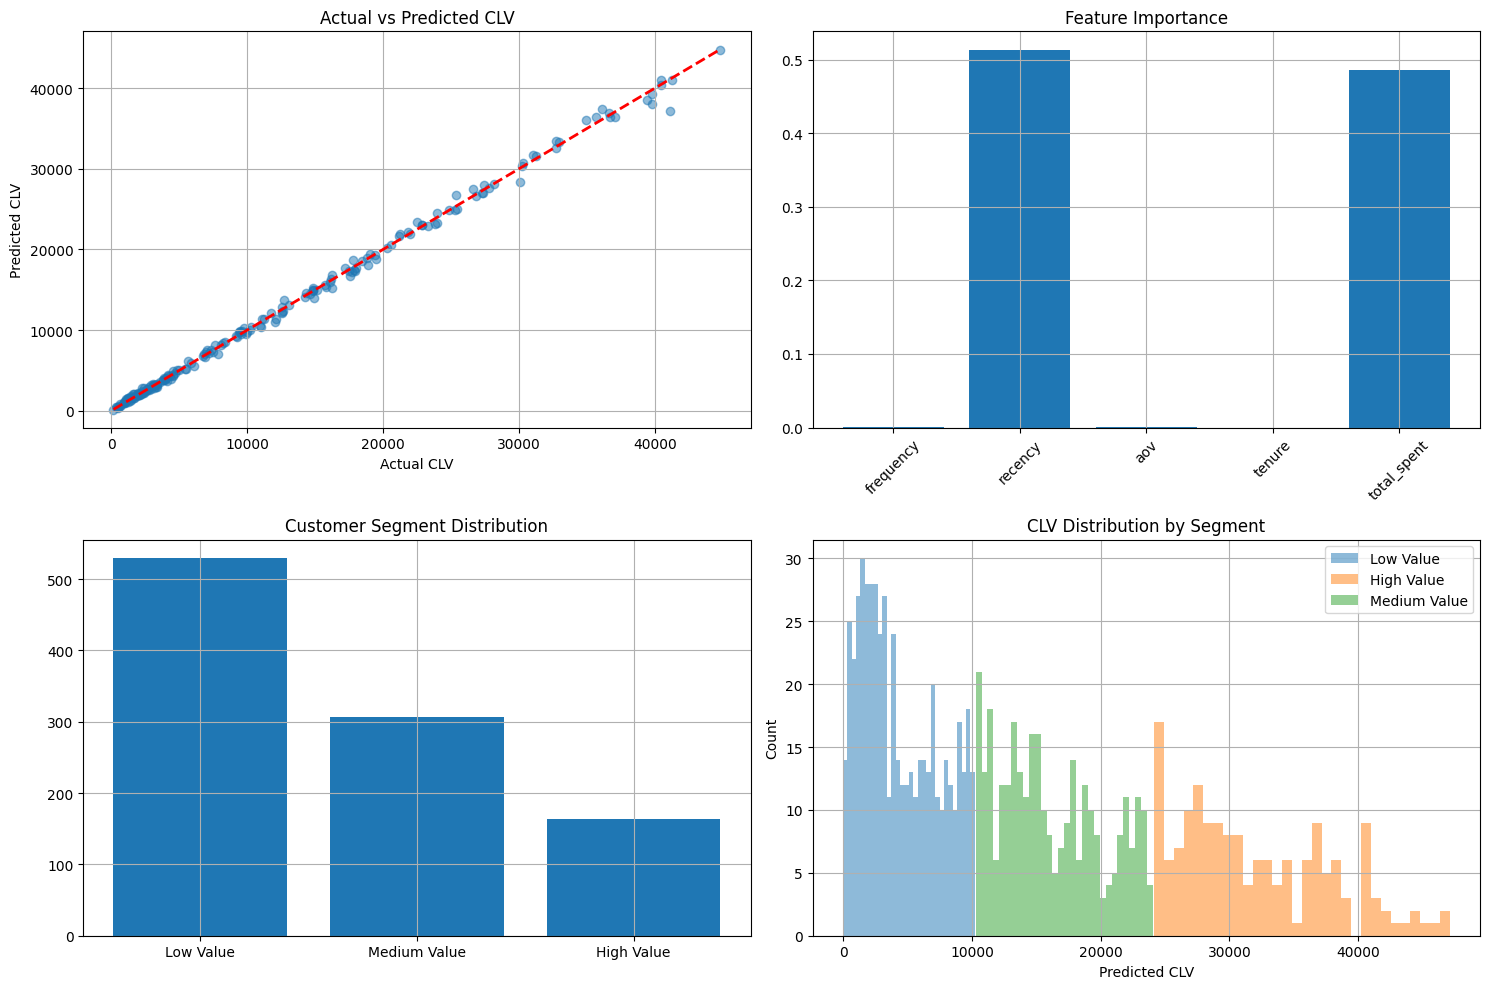

Model Performance Metrics:
Mean Absolute Error (MAE): 326.72
Root Mean Squared Error (RMSE): 514.80

Customer Segment Summary:
             predicted_CLV        total_spent     tenure
                      mean count         mean       mean
segment                                                 
High Value    32071.164062   164  8090.299512  48.085366
Low Value      4380.537109   529  3573.838166  21.374291
Medium Value  16138.629883   307  5808.100619  36.446254


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Loading and preprocessing data
def load_and_preprocess_data():
    # Assuming data is already in the provided CSV format
    df = pd.read_csv('21_customer_lifetime_value.csv')

    # Cleaning: Check for missing values and invalid types
    df = df.dropna()
    numeric_cols = ['purchase_history', 'tenure', 'total_spent', 'CLV']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()

    return df

# Feature engineering
def engineer_features(df):
    # Creating features: Frequency, Recency, AOV
    df['frequency'] = df['purchase_history'] / df['tenure']  # Purchases per month
    df['recency'] = df['tenure']  # Using tenure as proxy for recency
    df['aov'] = df['total_spent'] / df['purchase_history']  # Average Order Value

    # Handling potential infinities and NaNs
    df['frequency'] = df['frequency'].replace([np.inf, -np.inf], 0).fillna(0)
    df['aov'] = df['aov'].replace([np.inf, -np.inf], 0).fillna(0)

    return df

# Training the model
def train_model(df):
    # Features and target
    features = ['frequency', 'recency', 'aov', 'tenure', 'total_spent']
    X = df[features]
    y = df['CLV']

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Making predictions
    y_pred = model.predict(X_test_scaled)

    # Calculating metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, scaler, X_test, y_test, y_pred, mae, rmse

# Segmenting customers
def segment_customers(df, model, scaler):
    # Preparing features for all customers
    features = ['frequency', 'recency', 'aov', 'tenure', 'total_spent']
    X = df[features]
    X_scaled = scaler.transform(X)

    # Predicting CLV for all customers
    df['predicted_CLV'] = model.predict(X_scaled)

    # Clustering customers based on predicted CLV
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['segment'] = kmeans.fit_predict(df[['predicted_CLV']])

    # Labeling segments based on CLV
    segment_means = df.groupby('segment')['predicted_CLV'].mean().sort_values()
    segment_mapping = {
        segment_means.index[0]: 'Low Value',
        segment_means.index[1]: 'Medium Value',
        segment_means.index[2]: 'High Value'
    }
    df['segment'] = df['segment'].map(segment_mapping)

    return df

# Creating visualizations
def create_visualizations(df, X_test, y_test, y_pred, model):
    # Creating a figure with multiple subplots
    plt.figure(figsize=(15, 10))

    # 1. Actual vs Predicted CLV scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.title('Actual vs Predicted CLV')
    plt.grid(True)

    # 2. Feature importance plot
    plt.subplot(2, 2, 2)
    feature_importance = model.feature_importances_
    features = ['frequency', 'recency', 'aov', 'tenure', 'total_spent']
    plt.bar(features, feature_importance)
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.grid(True)

    # 3. Segment distribution
    plt.subplot(2, 2, 3)
    segment_counts = df['segment'].value_counts()
    plt.bar(segment_counts.index, segment_counts.values)
    plt.title('Customer Segment Distribution')
    plt.grid(True)

    # 4. CLV distribution by segment
    plt.subplot(2, 2, 4)
    for segment in df['segment'].unique():
        segment_data = df[df['segment'] == segment]['predicted_CLV']
        plt.hist(segment_data, bins=30, alpha=0.5, label=segment)
    plt.xlabel('Predicted CLV')
    plt.ylabel('Count')
    plt.title('CLV Distribution by Segment')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Loading and processing data
    df = load_and_preprocess_data()
    df = engineer_features(df)

    # Training model and getting predictions
    model, scaler, X_test, y_test, y_pred, mae, rmse = train_model(df)

    # Segmenting customers
    df = segment_customers(df, model, scaler)

    # Creating visualizations
    create_visualizations(df, X_test, y_test, y_pred, model)

    # Printing metrics
    print(f"Model Performance Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Printing segment summary
    print("\nCustomer Segment Summary:")
    print(df.groupby('segment').agg({
        'predicted_CLV': ['mean', 'count'],
        'total_spent': 'mean',
        'tenure': 'mean'
    }))

if __name__ == "__main__":
    main()